## Tutorial on Deep learning: Time Series forecasting
### Recurent Neural Networks: Develop an LSTM (Long Short-Term Memory)
* Air Pollution data
* Baseline model
* Vanilla LSTM model
* LSTM with scaled data
* StackedLSTM
* LTSM-CNN (optional)


### Populating namespace

In [ ]:
import pandas as pd
from matplotlib import pylab as plt
from datetime import datetime
import numpy as np
from math import sqrt
from numpy import concatenate
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import tensorflow as tf

### Air Pollution dataset ([Beijing PM2.5 Data Set](https://raw.githubusercontent.com/jbrownlee/Datasets/master/pollution.csv))
The dataset is collected from the US embassy in Beijing, China. It reports the Air quality and the weather each hour for five(5) years.
The data including the pollutant (PM2.5 concentration) to forecast is described with varibles listed below:
* No: row number
* year: year of data in this row
* month: month of data in this row
* day: day of data in this row
* hour: hour of data in this row
* pm2.5: PM2.5 concentration
* DEWP: Dew Point
* TEMP: Temperature
* PRES: Pressure
* cbwd: Combined wind direction
* Iws: Cumulated wind speed
* Is: Cumulated hours of snow
* Ir: Cumulated hours of rain

The Goal is to forecast the pollution at the next hour given history of pollution and weather condition



#### Download [Beijing PM2.5 Data Set](https://raw.githubusercontent.com/jbrownlee/Datasets/master/pollution.csv)

In [ ]:
!rm pollution.csv
!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/pollution.csv
!ls 

rm: cannot remove 'pollution.csv': No such file or directory
--2023-04-11 09:13:11--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/pollution.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2010492 (1.9M) [text/plain]
Saving to: ‘pollution.csv’

pollution.csv       100%[===================>]   1.92M  --.-KB/s    in 0.05s   

2023-04-11 09:13:11 (42.1 MB/s) - ‘pollution.csv’ saved [2010492/2010492]

pollution.csv  sample_data


<font color='red'>
<b>EXERCICES</b>: Replace the <b>FILL_IN</b> pattern with the correct codes then execute the cell
 </font>

In [ ]:
data = pd.read_csv('pollution.csv')
print(data.shape)
# Display the first (5) rows of the dataframe 
data.head()

(43824, 13)


,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [ ]:
# Check NAs (missing values) for all the columns
 #we use isna method in the dataframe to check whether an entry is NaN or not
 #if NaN then True else False.
data.isna()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,False,False,False,False,False,True,False,False,False,False,False,False,False
1,False,False,False,False,False,True,False,False,False,False,False,False,False
2,False,False,False,False,False,True,False,False,False,False,False,False,False
3,False,False,False,False,False,True,False,False,False,False,False,False,False
4,False,False,False,False,False,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43819,False,False,False,False,False,False,False,False,False,False,False,False,False
43820,False,False,False,False,False,False,False,False,False,False,False,False,False
43821,False,False,False,False,False,False,False,False,False,False,False,False,False
43822,False,False,False,False,False,False,False,False,False,False,False,False,False


In [ ]:
#count of missing values in each column
#since the isna output is True or False then we just sum to count the NaN 
#values for each column. In this case we found that pm2.5 has 2067 missing entries.
data.isna().sum()

No          0
year        0
month       0
day         0
hour        0
pm2.5    2067
DEWP        0
TEMP        0
PRES        0
cbwd        0
Iws         0
Is          0
Ir          0
dtype: int64

In [ ]:
# Check date types
#The info method outputs the column, Non-Null count and The Dtype
#The output below agrees with previous realization of pm2.5 as the only column
#with missing values.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43824 entries, 0 to 43823
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   No      43824 non-null  int64  
 1   year    43824 non-null  int64  
 2   month   43824 non-null  int64  
 3   day     43824 non-null  int64  
 4   hour    43824 non-null  int64  
 5   pm2.5   41757 non-null  float64
 6   DEWP    43824 non-null  int64  
 7   TEMP    43824 non-null  float64
 8   PRES    43824 non-null  float64
 9   cbwd    43824 non-null  object 
 10  Iws     43824 non-null  float64
 11  Is      43824 non-null  int64  
 12  Ir      43824 non-null  int64  
dtypes: float64(4), int64(8), object(1)
memory usage: 4.3+ MB


In [ ]:
#Check variable cbwd value occurences using value_counts.
#There are 4 unique entries i.e SE,NW,cv and NE.
data[['cbwd']].value_counts()

cbwd
SE      15290
NW      14150
cv       9387
NE       4997
dtype: int64

#### Reload, preprocess and visualize data
<font color='red'>
EXERCICE: Replace the <FILL_IN> with the correct codes to complete the code
 </font>

In [ ]:
# Load & format date
data = pd.read_csv('pollution.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=lambda d: datetime.strptime(d, '%Y %m %d %H'))
data.drop('No',axis=1,inplace=True)
# Fill all the NA with value  0
data.fillna(0,inplace=True)
# label encodeing of cbwd (wind direction feature): categories to numerics
encoder=LabelEncoder() # Create an instance of LabelEncoder
data['cbwd']=encoder.fit_transform(data['cbwd']) # use the fit__transform function to encode the data
# rename columns
data.rename(columns = {"pm2.5":"pollution","cbwd":"WINDdir","Iws":"WINDsped",	"Is":"SNOW",	"Ir":"RAIN"}, inplace=True)
data.index.name = 'datetime'
data.head()

,pollution,DEWP,TEMP,PRES,WINDdir,WINDsped,SNOW,RAIN
datetime,,,,,,,,
2010-01-01 00:00:00,0.0,-21,-11.0,1021.0,1,1.79,0,0
2010-01-01 01:00:00,0.0,-21,-12.0,1020.0,1,4.92,0,0
2010-01-01 02:00:00,0.0,-21,-11.0,1019.0,1,6.71,0,0
2010-01-01 03:00:00,0.0,-21,-14.0,1019.0,1,9.84,0,0
2010-01-01 04:00:00,0.0,-20,-12.0,1018.0,1,12.97,0,0


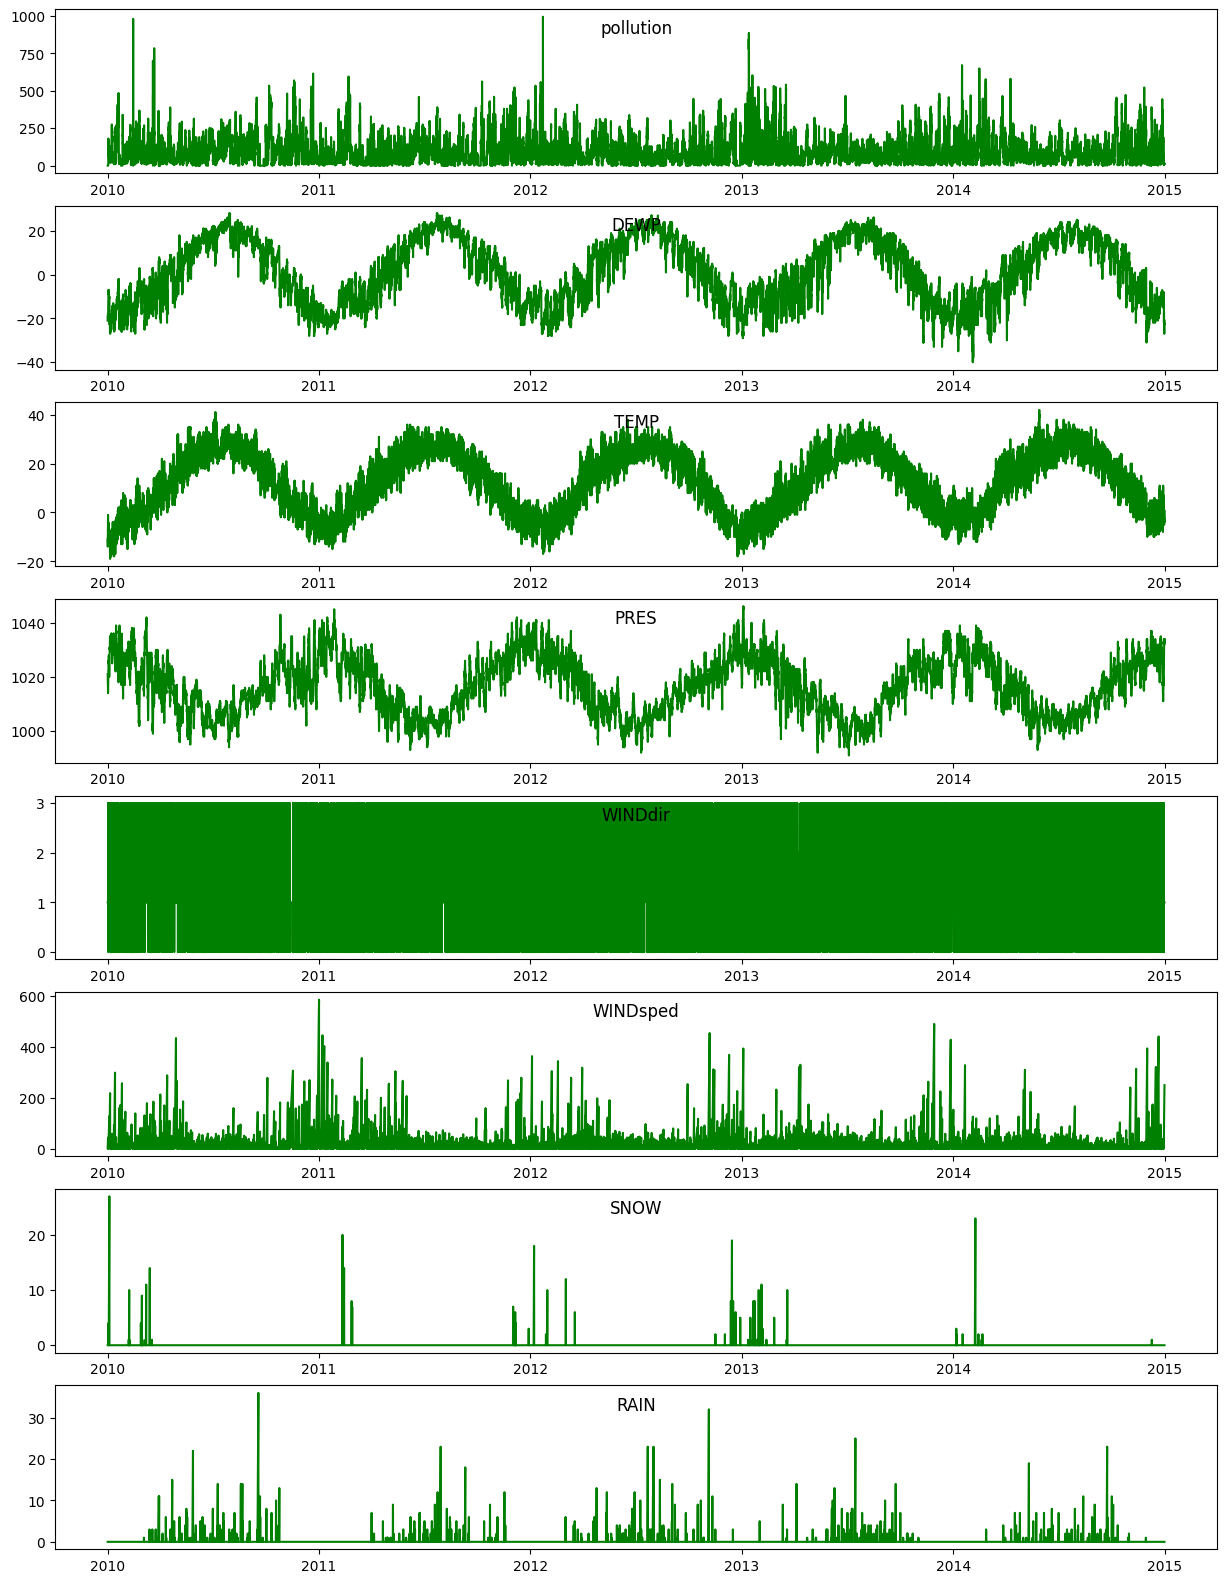

In [ ]:
plt.figure(figsize=(15,20))
list_vars = data.columns #("pollution",	"DEWP",	"TEMP",	"PRES",	"WINDsped",	"SNOW",	"RAIN")
for i, var in enumerate(list_vars):
  plt.subplot(data.shape[1], 1, i+1)
  plt.plot(data[var], color='green')
  plt.title(var,y=0.8)

<Axes: >

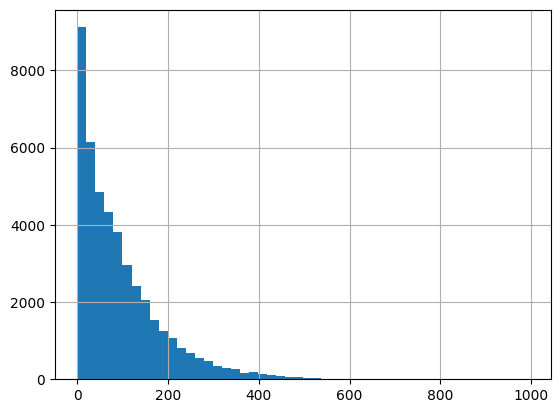

In [ ]:
data.pollution.hist(bins=50)

## Time serie forecasting as supervised learning problem (Regression setting)
* predict the pollution at the next hour (t) given the pollution and weather conditions at the prior time step

<font color='red'>
EXERCICE: Replace the <FILL_IN> with the correct codes to complete the code
 </font>

#### Prepare the pollution dataset for LSTM algorithm

In [ ]:
def history_and_horizon_sequencing(df, n_history, n_horizon, target=None):
  # History: look-back sequences (t-n, ... t-1)
  stack_history = []
  for i in range(n_history,0,-1):
    df_i = df.shift(i)
    df_i.columns = [f'{col}_t-{i}' for col in df_i.columns]
    stack_history =  stack_history + [df_i]
  # target dataframe
  if target is None: df_target = df
  else: df_target = df[target].to_frame()
  # Horizon: step-ahead sequences (t+1, ... t+n)
  stack_horizon = []
  for j in range(n_horizon,0,-1):
    df_j = df_target.shift(j) 
    df_j.columns = [f'{col}_t+{j}' for col in df_j.columns]
    stack_horizon = [df_j] + stack_horizon
  # Present: t
  df_t = df.copy()
  df_t.columns = [f'{col}_t' for col in df_t.columns]
  # return the concatenated data frame: past+present+future
  return pd.concat(stack_history+[df_t]+stack_horizon, axis=1)

In [ ]:
data_Xy = history_and_horizon_sequencing(data, 4, 1, target='pollution')
print(data_Xy.shape)
data_Xy.dropna(inplace=True)
print(data_Xy.shape)
data_Xy.head()

(43824, 41)
(43820, 41)


,pollution_t-4,DEWP_t-4,TEMP_t-4,PRES_t-4,WINDdir_t-4,WINDsped_t-4,SNOW_t-4,RAIN_t-4,pollution_t-3,DEWP_t-3,...,RAIN_t-1,pollution_t,DEWP_t,TEMP_t,PRES_t,WINDdir_t,WINDsped_t,SNOW_t,RAIN_t,pollution_t+1
datetime,,,,,,,,,,,,,,,,,,,,,
2010-01-01 04:00:00,0.0,-21.0,-11.0,1021.0,1.0,1.79,0.0,0.0,0.0,-21.0,...,0.0,0.0,-20,-12.0,1018.0,1,12.97,0,0,0.0
2010-01-01 05:00:00,0.0,-21.0,-12.0,1020.0,1.0,4.92,0.0,0.0,0.0,-21.0,...,0.0,0.0,-19,-10.0,1017.0,1,16.10,0,0,0.0
2010-01-01 06:00:00,0.0,-21.0,-11.0,1019.0,1.0,6.71,0.0,0.0,0.0,-21.0,...,0.0,0.0,-19,-9.0,1017.0,1,19.23,0,0,0.0
2010-01-01 07:00:00,0.0,-21.0,-14.0,1019.0,1.0,9.84,0.0,0.0,0.0,-20.0,...,0.0,0.0,-19,-9.0,1017.0,1,21.02,0,0,0.0
2010-01-01 08:00:00,0.0,-20.0,-12.0,1018.0,1.0,12.97,0.0,0.0,0.0,-19.0,...,0.0,0.0,-19,-9.0,1017.0,1,24.15,0,0,0.0


#### Baseline v0: persistance modeling
Use observation from the present time step (t) to predict the observation at the next time step (t+1).   

In [ ]:
#the baseline_persistence with return a value at t+1 given t

def baseline_persistance(serie_t):
  # forecast: predict t+1 with value of t
  return serie_t.shift(1)

def compute_performance(test, forecast, start_t=400, end_t=500):
  rmse=mean_squared_error(test,forecast) # Compute root mean squared error between test and forecast
  print('RMSE: %.3f' % rmse)
  plt.figure(figsize=(15,5))
  plt.plot(test[start_t:end_t], color='b',label='test')
  plt.plot(forecast[start_t:end_t], color='r',label='forecast')
  plt.legend()

RMSE: 760.019


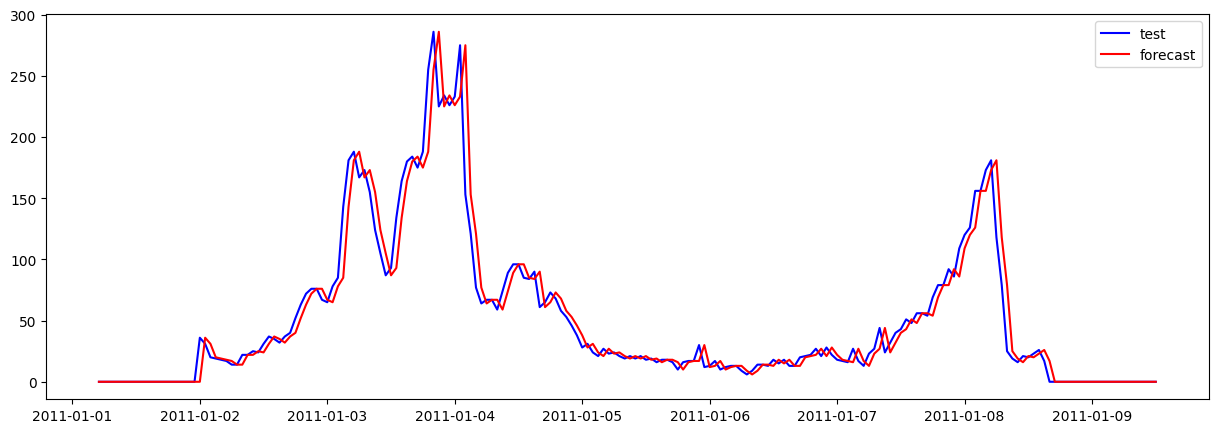

In [ ]:
test_y, persistance_yhat = data_Xy['pollution_t'][1:], baseline_persistance(data_Xy['pollution_t'])[1:] 
compute_performance(test_y, persistance_yhat, start_t=365*24, end_t=365*24+200)

#### LSTM model

#### Split data into train and test sets 
Build train and test dataset for training the model on the first one(1) year and prediction of the four(4) lastest years

In [ ]:
def split_train_test(values, n_train_hours = 365*24):
  # Split the data into train (use values before n_train_hours) and test sets (use values after n_train_hours)
  train=values[:n_train_hours,:]
  test=values[n_train_hours:,:]
  # split into input and outputs
  train_X, train_y = train[:, :-1], train[:, -1]
  test_X, test_y = test[:, :-1], test[:, -1]
  # reshape input to be 3D [samples, timesteps, features] required for LSTM
  train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
  test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
  print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
  return train_X, train_y, test_X, test_y

In [ ]:
train_X, train_y, test_X, test_y = split_train_test(data_Xy.values)

(8760, 1, 40) (8760,) (35060, 1, 40) (35060,)


#### Build an LSTM model

In [ ]:
def build_lstm_model(input_shape, nb_neurons = 50):
  '''
  train and test: input shape 1 time step with 8 features
  LSTM:
   * nb_neurons: hidden state
   * 1 neuron for output layer for prediction.
  '''
  model = Sequential()
  # Add an LSTM layer with nb_neurons and input_shape=input_shape
  model.add(LSTM(nb_neurons,input_shape=input_shape))
  model.add(Dense(1, activation='relu'))  # Add a Dense layer with one output neuron
  # model compile
  model.compile(loss='mae', optimizer='adam')
  # Train the model
  return model

def train_model(model, train_X, train_y, test_X, test_y, epochs=500, batch_size=72, verbose=0):
  '''
  Generic function to train model
  '''
  callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=77,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)
  history = model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size, validation_data=(test_X, test_y), callbacks=[callback], verbose=verbose, shuffle=False)
  plt.plot(history.history['loss'], label='train')
  plt.plot(history.history['val_loss'], label='test')
  plt.legend()
  plt.show()

Epoch 1/500
122/122 [==============================] - 9s 25ms/step - loss: 94.7354 - val_loss: 91.1644
Epoch 2/500
122/122 [==============================] - 2s 17ms/step - loss: 93.1647 - val_loss: 89.5750
Epoch 3/500
122/122 [==============================] - 2s 16ms/step - loss: 91.7847 - val_loss: 87.9864
Epoch 4/500
122/122 [==============================] - 2s 15ms/step - loss: 90.4618 - val_loss: 86.7034
Epoch 5/500
122/122 [==============================] - 3s 27ms/step - loss: 89.2927 - val_loss: 85.4938
Epoch 6/500
122/122 [==============================] - 4s 29ms/step - loss: 88.1711 - val_loss: 84.3574
Epoch 7/500
122/122 [==============================] - 2s 17ms/step - loss: 87.1039 - val_loss: 83.3054
Epoch 8/500
122/122 [==============================] - 2s 13ms/step - loss: 86.1006 - val_loss: 82.3250
Epoch 9/500
122/122 [==============================] - 1s 10ms/step - loss: 85.1177 - val_loss: 81.2162
Epoch 10/500
122/122 [==============================] - 1s 8ms/s

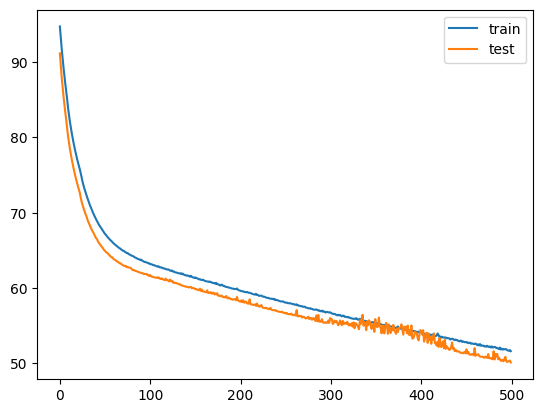

In [ ]:
# Build and train the model
input_shape=(train_X.shape[1], train_X.shape[2])
# Build and train the model using the build_lstm_model (new instance lstm_model)
lstm_model=build_lstm_model(input_shape)
# Train the new model using train_model method with params lstm_model, train_X, train_y, test_X, test_y, epochs=100, batch_size=72, verbose=0
train_model(lstm_model,train_X, train_y, test_X, test_y, epochs=500, batch_size=72, verbose=1)

1096/1096 [==============================] - 2s 1ms/step
RMSE: 6838.791


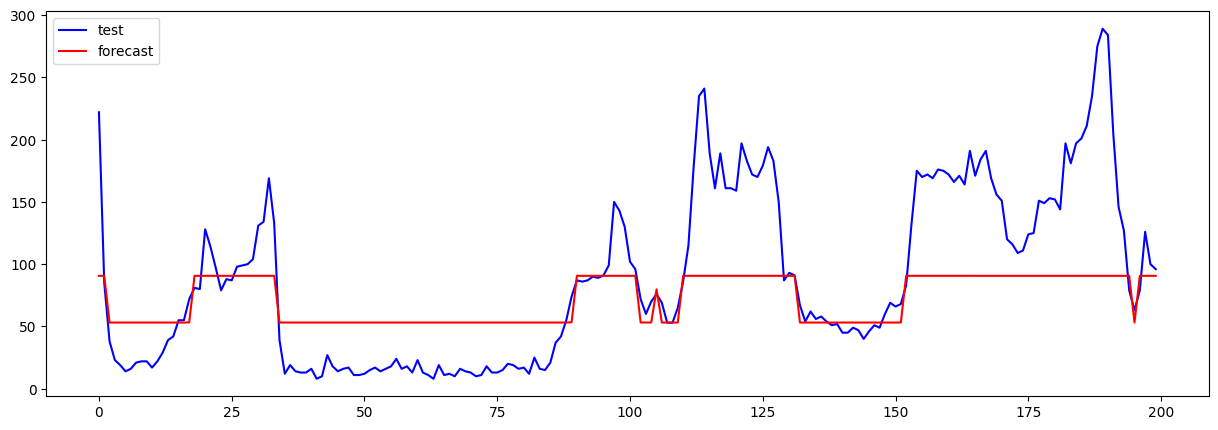

In [ ]:
# make the prediction of test_X (store in lstm_yhat)
lstm_yhat = lstm_model.predict(test_X)
# compute performance
compute_performance(test_y, lstm_yhat, start_t=365*24, end_t=365*24+200)

#### LSTM trained with scaling data

In [ ]:
# Normalize features
values = data_Xy.values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_values = scaler.fit_transform(values)
# Create train/tests datasets from scaled_data
scaled_train_X, scaled_train_y, scaled_test_X, scaled_test_y = split_train_test(scaled_values)

(8760, 1, 40) (8760,) (35060, 1, 40) (35060,)


Epoch 1/500
122/122 [==============================] - 4s 14ms/step - loss: 0.0387 - val_loss: 0.0399
Epoch 2/500
122/122 [==============================] - 1s 8ms/step - loss: 0.0166 - val_loss: 0.0280
Epoch 3/500
122/122 [==============================] - 2s 13ms/step - loss: 0.0117 - val_loss: 0.0110
Epoch 4/500
122/122 [==============================] - 2s 13ms/step - loss: 0.0107 - val_loss: 0.0109
Epoch 5/500
122/122 [==============================] - 1s 9ms/step - loss: 0.0087 - val_loss: 0.0110
Epoch 6/500
122/122 [==============================] - 2s 13ms/step - loss: 0.0094 - val_loss: 0.0180
Epoch 7/500
122/122 [==============================] - 1s 9ms/step - loss: 0.0080 - val_loss: 0.0142
Epoch 8/500
122/122 [==============================] - 2s 13ms/step - loss: 0.0096 - val_loss: 0.0067
Epoch 9/500
122/122 [==============================] - 2s 15ms/step - loss: 0.0073 - val_loss: 0.0062
Epoch 10/500
122/122 [==============================] - 1s 8ms/step - loss: 0.0070 - 

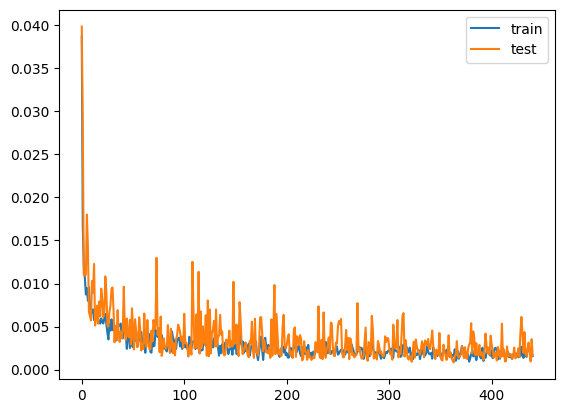

In [ ]:
# Build and train the model using the build_lstm_model (new instance name lstm_model_scaled)
input_shape=(scaled_train_X.shape[1], scaled_train_X.shape[2])
lstm_model_scaled=build_lstm_model(input_shape)
# Train the new model using train_model method as previousely using the new scaled data
train_model(lstm_model_scaled,scaled_train_X, scaled_train_y, scaled_test_X, scaled_test_y, epochs=500, batch_size=72, verbose=1)

In [ ]:
# invert scaling for forecast
def invert_scaling(scaled_X, scaled_yhat):
  scaled_tX = scaled_test_X.reshape((scaled_X.shape[0], scaled_X.shape[2]))
  Xyat = concatenate((scaled_tX, scaled_yhat.reshape(-1,1)), axis=1)
  inv_Xyat = scaler.inverse_transform(Xyat)
  return inv_Xyat[:,-1]

1096/1096 [==============================] - 2s 2ms/step
RMSE: 2.184


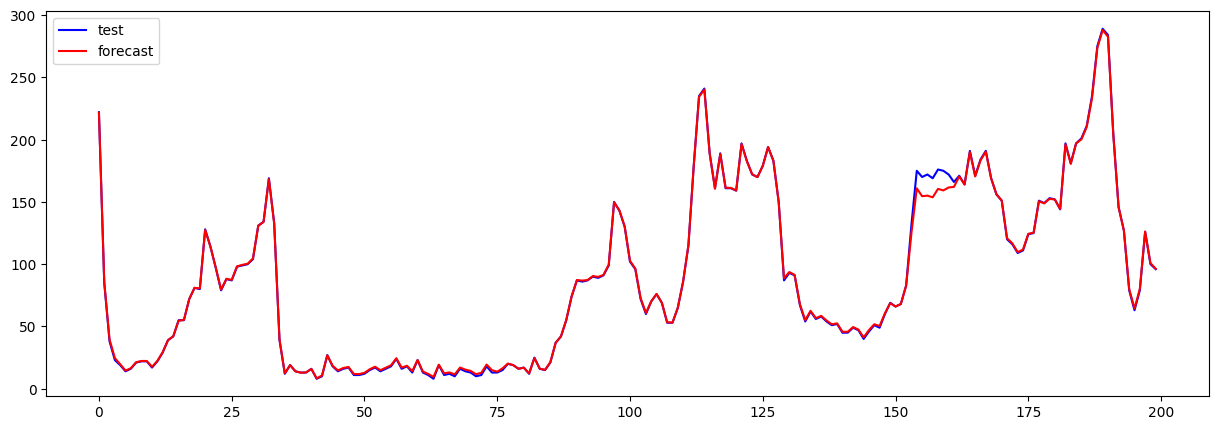

In [ ]:
# make a prediction
lstm_scaled_yhat = lstm_model_scaled.predict(scaled_test_X)
# compute performance
inv_yhat = invert_scaling(scaled_test_X, lstm_scaled_yhat)
compute_performance(test_y, inv_yhat, start_t=365*24, end_t=365*24+200)

#### Build an Stacked LSTM model

Stacked LSTM model refers to stacking multiple hidden LSTM layers one on top of another.

In [ ]:
def build_stacked_lstm_model(input_shape, nb_neurons = 50):
  model = Sequential()
  # Add an LSTM layer with nb_neurons and input_shape=input_shape and return_sequences=True (required sequences needed for next LSTM Bloc)
  model.add(LSTM(nb_neurons,input_shape=input_shape,return_sequences=True))
  # Add an additional LSTM layer with nb_neurons and 'relu' activation function 
  model.add(LSTM(nb_neurons,activation='relu'))
  # Add a Dense layer with one output neuron
  model.add(Dense(1, activation='relu'))
  # Train the model
  model.compile(loss='mae', optimizer='adam')
  return model

Epoch 1/500
122/122 [==============================] - 6s 19ms/step - loss: 0.0521 - val_loss: 0.0532
Epoch 2/500
122/122 [==============================] - 2s 15ms/step - loss: 0.0184 - val_loss: 0.0187
Epoch 3/500
122/122 [==============================] - 2s 13ms/step - loss: 0.0126 - val_loss: 0.0142
Epoch 4/500
122/122 [==============================] - 2s 15ms/step - loss: 0.0111 - val_loss: 0.0151
Epoch 5/500
122/122 [==============================] - 1s 10ms/step - loss: 0.0098 - val_loss: 0.0099
Epoch 6/500
122/122 [==============================] - 2s 14ms/step - loss: 0.0100 - val_loss: 0.0147
Epoch 7/500
122/122 [==============================] - 1s 10ms/step - loss: 0.0098 - val_loss: 0.0077
Epoch 8/500
122/122 [==============================] - 1s 11ms/step - loss: 0.0084 - val_loss: 0.0132
Epoch 9/500
122/122 [==============================] - 2s 14ms/step - loss: 0.0081 - val_loss: 0.0128
Epoch 10/500
122/122 [==============================] - 2s 16ms/step - loss: 0.007

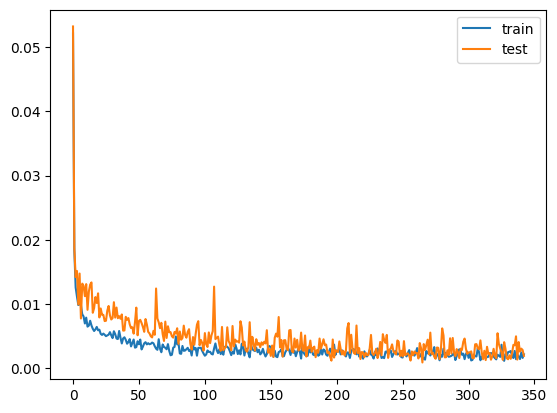

In [ ]:
input_shape = (train_X.shape[1], train_X.shape[2]) 
# Build the new stacked_lstm_model
stacked_lstm_model=build_stacked_lstm_model(input_shape)
# Train the new model using train_model method as previousely using the new scaled data
train_model(stacked_lstm_model,scaled_train_X, scaled_train_y, scaled_test_X, scaled_test_y, epochs=500, batch_size=72, verbose=1)# Train the model stacked_lstm_model


1096/1096 [==============================] - 2s 2ms/step
RMSE: 3.441


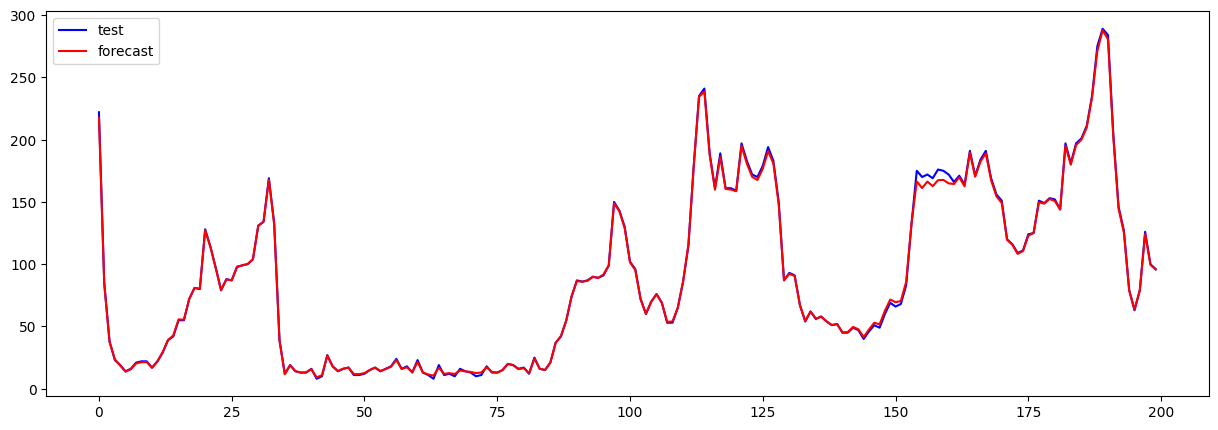

In [ ]:
# make a prediction with stacked_lstm_model using scaled_test_X (output in variable scaled_stacked_lstm_yhat)
scaled_stacked_lstm_yhat=stacked_lstm_model.predict(scaled_test_X)
# compute performance
inv_yhat = invert_scaling(scaled_test_X, scaled_stacked_lstm_yhat)
compute_performance(test_y, inv_yhat, start_t=365*24, end_t=365*24+200)

## Assignment: Work to improve the performance - try different strategies:
* Hyperparameters tuning
* Test other models: 
 - Eg. 1D-ConvNet LSTM, Bidirectional

##Tune the stacked model by changing the number of layers and also the number of neurona in each. Also, we could change the learning rate, optimizer,batch size and activation functions.

In [ ]:
def tuned_build_stacked_lstm_model(input_shape, nb_neurons = 200):
  model = Sequential()
  # Add an LSTM layer with nb_neurons and input_shape=input_shape and return_sequences=True (required sequences needed for next LSTM Bloc)
  model.add(LSTM(nb_neurons,input_shape=input_shape))
 #add a dense
  model.add(Dense(1, activation='relu'))
  # Train the model
  model.compile(loss='mae', optimizer='adam')
  return model

In [ ]:
input_shape = (train_X.shape[1], train_X.shape[2]) 
# Build the new stacked_lstm_model
tuned_stacked_lstm_model=tuned_build_stacked_lstm_model(input_shape)
# Train the new model using train_model method as previousely using the new scaled data
train_model(tuned_stacked_lstm_model,scaled_train_X, scaled_train_y, scaled_test_X, scaled_test_y, epochs=500, batch_size=72, verbose=1)# Train the model stacked_lstm_model

Epoch 1/500
122/122 [==============================] - 6s 32ms/step - loss: 0.0332 - val_loss: 0.0173
Epoch 2/500
122/122 [==============================] - 2s 16ms/step - loss: 0.0148 - val_loss: 0.0096
Epoch 3/500
122/122 [==============================] - 2s 18ms/step - loss: 0.0124 - val_loss: 0.0092
Epoch 4/500
122/122 [==============================] - 2s 18ms/step - loss: 0.0081 - val_loss: 0.0110
Epoch 5/500
122/122 [==============================] - 2s 18ms/step - loss: 0.0123 - val_loss: 0.0188
Epoch 6/500
122/122 [==============================] - 3s 28ms/step - loss: 0.0110 - val_loss: 0.0093
Epoch 7/500
122/122 [==============================] - 2s 16ms/step - loss: 0.0081 - val_loss: 0.0141
Epoch 8/500
122/122 [==============================] - 2s 17ms/step - loss: 0.0082 - val_loss: 0.0115
Epoch 9/500
122/122 [==============================] - 2s 16ms/step - loss: 0.0088 - val_loss: 0.0141
Epoch 10/500
122/122 [==============================] - 2s 16ms/step - loss: 0.009

In [ ]:
# make a prediction with stacked_lstm_model using scaled_test_X (output in variable scaled_stacked_lstm_yhat)
scaled_stacked_lstm_yhat=tuned_stacked_lstm_model.predict(scaled_test_X)
# compute performance
inv_yhat = invert_scaling(scaled_test_X, scaled_stacked_lstm_yhat)
compute_performance(test_y, inv_yhat, start_t=365*24, end_t=365*24+200)